# Deep Learning-Based Groundwater Level prediction for the Virginia Eastern Shore

# Lag Analysis for Groundwater Depth  Prediction

### Setup & Import

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

### Define paths

In [21]:
# Project paths
load_path = Path("../data/processed")
sites = ['capecharles', 'churchneck', 'greenbush', 'withams']
merged_dfs = {}

### Load data

In [22]:
merged_dfs = {}
for site in sites:
    file_path = load_path / f"gw_{site}.csv"
    df = pd.read_csv(file_path, parse_dates=['date'])
    df = df.set_index('date')
    merged_dfs[site] = df
    print(f"Loaded {site}: {df.shape}")

Loaded capecharles: (6667, 10)
Loaded churchneck: (6667, 10)
Loaded greenbush: (6667, 10)
Loaded withams: (6667, 10)


### Available columns

In [4]:
site = sites[0]
df_sample = merged_dfs[site]
print("Available columns:", list(df_sample.columns))

Available columns: ['gw_depth_ft', 'Evapotranspiration(inch)', 'Precipitation(inch)', 'Mean_soil_moisture(m^3/m^3)', 'Mean_temperaturen(°F)', 'Mean_surface_pressure(hPa)', 'Mean_wind_speed(mp/h)', 'Mean_soil_temperature(°F)', 'Max_vapour_pressure_deficit (kPa)', 'Mean_wet_bulb_temperature (°F)']


### Lag Correlation Function

In [5]:
def analyze_lags(df, target, feature, max_lag=30):
    results = {'lags': [], 'corrs': []}
    for lag in range(-max_lag, max_lag+1):
        corr = df[target].corr(df[feature].shift(lag))
        results['lags'].append(lag)
        results['corrs'].append(corr)
    
    # Find best lag
    best_idx = np.argmax(results['corrs'])
    return results['lags'][best_idx], results['corrs'][best_idx]

### Precipitation Lag Test
There is a poor relationship ($r < .03$) in the daily precipitation to groundwater levels at each of the study sites; this would indicate that the aquifer does not react to precipitation events individually and that recharge occurs either cumulatively through time or after a period of infiltration into the vadose zone. Therefore, for modeling purposes, untransformed daily precipitation values are a "noisy" predictor and will likely need to be transformed (i.e., through the use of rolling sums) before they can be used effectively

In [6]:
print("Precipitation Lags:")
precip_results = {}
for site in sites:
    df = merged_dfs[site].dropna()
    lag, corr = analyze_lags(df, 'gw_depth_ft', 'Precipitation(inch)', 45)
    precip_results[site] = {'lag': lag, 'corr': corr}
    print(f"{site}: {lag} days, r={corr:.3f}")

Precipitation Lags:
capecharles: -39 days, r=0.009
churchneck: -23 days, r=0.019
greenbush: -7 days, r=0.026
withams: -1 days, r=0.001


### Evapotranspiration(ET) lag test
ET has a strong effect on groundwater compared to daily precipitation and has a consistent 30 day lag and was correlated as high as r = .471 (Cape Charles). This demonstrates that the water table is somwhat controlled by the seasonal atmospheric demand. The 30 day lag represents the "memory" of the system where the total amount of heat and water taken up by plants during the prior month controls the rate of groundwater level decline for the current month.

In [7]:
print("\nEvapotranspiration Lags:")
et_results = {}

for site in sites:
    df = merged_dfs[site].dropna()
    
    if 'Evapotranspiration(inch)' in df.columns:
        lag, corr = analyze_lags(df, 'gw_depth_ft', 'Evapotranspiration(inch)', 30)
        et_results[site] = {'lag': lag, 'corr': corr}
        print(f"{site}: {lag} days, r={corr:.3f}")
    else:
        print(f"{site}: No ET data")


Evapotranspiration Lags:
capecharles: 30 days, r=0.471
churchneck: 30 days, r=0.179
greenbush: 28 days, r=0.350
withams: 30 days, r=0.304


### GW depth autocorrelation
The aquifers exhibit extreme persistence and there is almost no decay in the autocorrelation function out to 30 days; this is confirmed by the high value of the first order autocorrelation coefficient (near 0.998). Therefore, the present state of the groundwater is the best single predictor of its future state. Although all four locations have a long memory, the sites at Cape Charles, Church Neck and Withams had a longer memory than at Greenbush (which had a memory of approximately 10 days). This is indicative of a "flashier" site and implies that the location at Greenbush has a higher hydraulic conductivity and/or a lower saturated thickness of the aquifer than the other three locations and therefore reacts to changes in climate on a shorter time scale than the other three locations.

In [23]:
print("\nGW Depth Autocorrelation (Memory):")
gw_results = {}

for site in sites:
    df = merged_dfs[site].dropna()
    series = df['gw_depth_ft']
    
    # gw autocorrelation for lags 1 to 30 days
    autocorrs = [series.autocorr(lag=lag) for lag in range(1, 31)]
    
    # first lag where the correlation drops below 0.5
    persistence_days = next((lag for lag, corr in enumerate(autocorrs, 1) if corr < 0.5), 30)
    
    gw_results[site] = {
        'persistence': persistence_days,
        'autocorr_lag1': autocorrs[0]
    }
    
    print(f"{site}: {persistence_days} days above 0.5, lag1={autocorrs[0]:.3f}")



GW Depth Autocorrelation (Memory):
capecharles: 30 days above 0.5, lag1=0.998
churchneck: 30 days above 0.5, lag1=0.997
greenbush: 10 days above 0.5, lag1=0.892
withams: 30 days above 0.5, lag1=0.998


### Summary

In [9]:
print("\nSummary of Best Lags:")
print("-" * 50)
print("Site\t\tPrecip Lag\tET Lag\t\tGW Memory")
print("-" * 50)

for site in sites:
    precip_lag = precip_results[site]['lag']
    et_lag = et_results.get(site, {}).get('lag', 'N/A')
    gw_memory = gw_results[site]['persistence']
    
    print(f"{site:15}{precip_lag:8}\t{et_lag:8}\t{gw_memory:8}")


Summary of Best Lags:
--------------------------------------------------
Site		Precip Lag	ET Lag		GW Memory
--------------------------------------------------
capecharles         -39	      30	      30
churchneck          -23	      30	      30
greenbush            -7	      28	      10
withams              -1	      30	      30


### Feature Engineeing

In [10]:
for site in sites:
    df = merged_dfs[site]
    
    # 1. GW Memory (previous days)
    df['gw_lag1'] = df['gw_depth_ft'].shift(1)
    
    # 2. 30-Day Evap Lag 
    df['evap_lag30'] = df['Evapotranspiration(inch)'].shift(30)
    
    # 3. Cumulative precipitation:7-day rolling sum 
    df['precip_7d'] = df['Precipitation(inch)'].rolling(window=7).sum()
    
    # 4. remove NaNs created by the shifts/rolling
    merged_dfs[site] = df.dropna()

print(f" Features updated for all sites. New columns: {list(merged_dfs['withams'].columns)}")

 Features updated for all sites. New columns: ['gw_depth_ft', 'Evapotranspiration(inch)', 'Precipitation(inch)', 'Mean_soil_moisture(m^3/m^3)', 'Mean_temperaturen(°F)', 'Mean_surface_pressure(hPa)', 'Mean_wind_speed(mp/h)', 'Mean_soil_temperature(°F)', 'Max_vapour_pressure_deficit (kPa)', 'Mean_wet_bulb_temperature (°F)', 'gw_lag1', 'evap_lag30', 'precip_7d']


In [11]:
# save the change with _l extension
save_path = Path("../data/processed")
for site_name, df in merged_dfs.items():
    file_name = f"gw_{site_name}_l.csv"
    
    
    df.to_csv(save_path / file_name, index=True)

### All independent variables correlaton coefficient 
The correlation results from the four study wells reveal that gw_lag1, mean soil moisture, evp_lag30 and mean soil temperature are the best predictors of groundwater depth; with those features being significantly more effective than the direct effects of daily precipitation. In this context,gw_lag1 is thebest predictor with a correlation of 1.0 (or 0.89 at Greenbush). soil moisture displays a significant negative correlation (as large as -0.59 in Withams), which represents the main mechanism of aquifer recharge; representing when there is sufficient water to be physically transferred into the system.

On the other hand, soil temperature has a very high positive correlation (up to 0.58 in Cape Charles); representing the potential seasonal variation in discharge due to increased evapotranspiration rates and subsequent lowering of the water table during warmer months. As expected, the precipitation lags (7D) demonstrate much weaker correlations to groundwater levels, however, the precipitation lag values represent an important component of the hydraulic systems "memory"; while the soil based metrics represent the most immediate and largest signals to the CNN-LSTM model.

The best features for prediction of groundwater depth for this project are gw_lag_1(Most important), mean soil moisture, Mean_temperature, Mean_soil_temperature, evap_lag30, month and day_of_year        

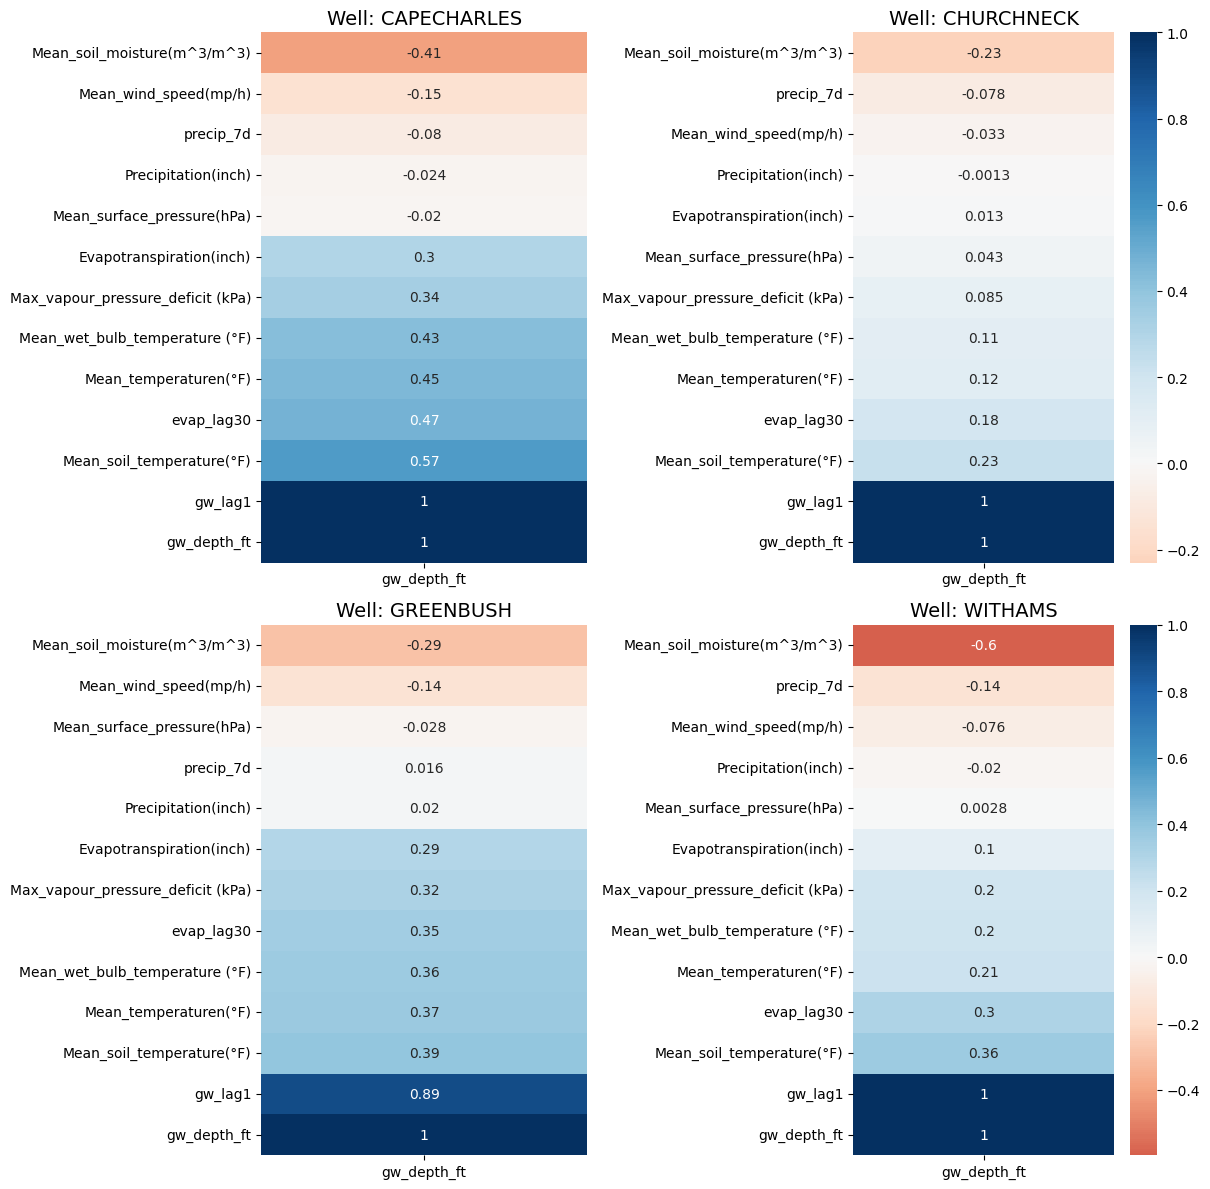

In [13]:
#  well list 
wells = ['capecharles', 'churchneck', 'greenbush', 'withams']
processed_path = Path("../data/processed")

#  2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes = axes.flatten()  # Flatten to easily loop through them

for i, name in enumerate(wells):
    
    # Load data
    file_path = processed_path / f"gw_{name}_l.csv"
    df = pd.read_csv(file_path)
    
    # compute correlation matrix
    cor = df.drop(columns=['date']).corr()
    
    # correlation with gw depth
    target_cor = cor[['gw_depth_ft']].sort_values(by='gw_depth_ft')
    
    # 3. Plot heat map
    sns.heatmap(target_cor, annot=True, cmap='RdBu', center=0,
                ax=axes[i], cbar=(i in [1,3]))
    
    axes[i].set_title(f"{well.upper()}", fontsize=14

# layout 
plt.tight_layout()
plt.show()

### Variance Inflation Factor (VIF)
The Variance Inflation Factor (VIF) was used to measure multicolinearity among environmental predictors. Variables that exceeded a VIF value of 10, as defined by Kutner et al. (2004) were eliminated from the final feature set to maintain the stability of the regression coefficients

The Variance Inflation Factor (VIF) analysis indicated that there is significant multi-collinearity among atmospheric variables in particular among Mean Temperature and Wet Bulb Temperature with each having VIF values greater than 300. This degree of redundancy may be unstable for a linear regression model as it may lead to unreliable coefficient estimates and an over-estimated variance in error

Daily Precipitation and Evapotranspiration were replaced by 7-day Cumulative Rainfall and 30-day lagged evapotranspiration to better capture the delayed response time of the aquifer system.

Maximum vapor pressure deficit (kPa) was dropped as its VIF was 9.5 at Withams. Because maximum vapor pressure deficit is a function of temperature and humidity, soil temperature and soil moisture provide redundant information when included in the model.

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler


def check_vif(df, well_name):
    # 1. Select only the features (exclude target 'gw_depth_ft')
    features = [col for col in df.columns if col != 'gw_depth_ft']
    X = df[features]
    
    # 2. Standardize features (important for VIF accuracy)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    
    print(f"\n--- VIF Results for {well_name.upper()} ---")
    print(vif_data.sort_values(by="VIF", ascending=False))

# Check for the four wells
for site, df in merged_dfs.items():
    check_vif(df, site)


--- VIF Results for CAPECHARLES ---
                              Feature         VIF
3               Mean_temperaturen(°F)  345.746928
8      Mean_wet_bulb_temperature (°F)  244.433688
6           Mean_soil_temperature(°F)    9.468325
0            Evapotranspiration(inch)    7.051027
7   Max_vapour_pressure_deficit (kPa)    5.966095
10                         evap_lag30    2.891405
2         Mean_soil_moisture(m^3/m^3)    1.717740
9                             gw_lag1    1.574972
1                 Precipitation(inch)    1.561490
5               Mean_wind_speed(mp/h)    1.458455
4          Mean_surface_pressure(hPa)    1.382887
11                          precip_7d    1.257384

--- VIF Results for CHURCHNECK ---
                              Feature         VIF
3               Mean_temperaturen(°F)  346.882819
8      Mean_wet_bulb_temperature (°F)  245.706397
6           Mean_soil_temperature(°F)    8.869402
0            Evapotranspiration(inch)    7.189298
7   Max_vapour_pressure_def

### Final features for ML model Development

In [16]:
# The final, statistically sound list
final_features = [
    'gw_depth_ft', 
    'gw_lag1', 
    'Mean_soil_temperature(°F)', 
    'Mean_soil_moisture(m^3/m^3)', 
    'evap_lag30', 
    'precip_7d'
]
save_path = Path("../data/processed")

for site in sites:
    # Update memory
    merged_dfs[site] = merged_dfs[site][final_features]
    
    # SAVE to my PC
    file_name = f"gw_{site}_ML_READY.csv"
    merged_dfs[site].to_csv(save_path / file_name)
    print(f"Saved lean dataset to: {file_name}")

print("\n the CSV files now only contain the 6 statistically sound features.")

Saved lean dataset to: gw_capecharles_ML_READY.csv
Saved lean dataset to: gw_churchneck_ML_READY.csv
Saved lean dataset to: gw_greenbush_ML_READY.csv
Saved lean dataset to: gw_withams_ML_READY.csv

 the CSV files now only contain the 6 statistically sound features.


### Trend Analysis using Mann–Kendall (MK)
To determine whether or not the trends identified were statistically significant, p-values were calculated for each site at a 95% confidence level ($\alpha=0.05$). According to the procedures developed by Mann (1945) and Kendall (1975), a trend will be determined to be statistically significant if it can be shown that $p<0.05$; i.e., it is highly likely that the trend did not occur by chance.

The Mann-Kendall trend test was used to evaluate the trends in daily groundwater level data collected at four different locations for the time period of 2007-2025. All of these stations exhibited significantly different hydrogeologic behavior. The station exhibiting the most severe long-term decline is Greenbush. The trend of decreasing groundwater level at Greenbush is statistically significant ($p<0.001$) with an average annual rate of decrease of about 0.26 ft/year (Sen's Slope), resulting in a total decline of the water table of about 4.6 feet. Although less pronounced than Greenbush, Churchneck showed a trend of declining groundwater levels as well. However, the other two stations showed trends of slightly increasing or no trend in groundwater levels. Specifically, the trend in groundwater levels at Cape Charles has shown a slight upward trend, whereas the trend at Withams Station has been found to be statistically insignificant and therefore classified as "no trend" ($p=0.088$). These results indicate that although there have been regional changes in climate over this time period, the response of the aquifers has been heterogeneous, with Greenbush exhibiting a high degree of susceptibility to long-term loss of storage capacity due to the effects of declining groundwater levels.

In [16]:
p = Path("../data/processed")
wells = ['capecharles','churchneck','greenbush','withams']
for w in wells:
    d = pd.read_csv(p/f"gw_{w}_ML_READY.csv", index_col='date', parse_dates=True)
    r = mk.original_test(d.gw_depth_ft)
    print(f"{w.upper()}: trend={r.trend}, p={r.p:.4f}, slope={r.slope*365:.6f} ft/year")

CAPECHARLES: trend=decreasing, p=0.0000, slope=-0.014880 ft/year
CHURCHNECK: trend=increasing, p=0.0022, slope=0.009114 ft/year
GREENBUSH: trend=increasing, p=0.0000, slope=0.258391 ft/year
WITHAMS: trend=no trend, p=0.0879, slope=-0.003745 ft/year


In [17]:
results = []
for w in wells:
    d = pd.read_csv(p/f"gw_{w}_ML_READY.csv", index_col='date', parse_dates=True)
    r = mk.original_test(d.gw_depth_ft.dropna())
    
    # Store results in a dictionary
    results.append({
        'Well': w.upper(),
        'Trend': r.trend.capitalize(),
        'P-Value': round(r.p, 4),
        'Slope (ft/yr)': round(r.slope * 365, 4)
    })

In [18]:
df_results = pd.DataFrame(results)
df_results['Significant'] = df_results['P-Value'] < 0.05
df_results

,Well,Trend,P-Value,Slope (ft/yr),Significant
0,CAPECHARLES,Decreasing,0.0000,-0.0149,True
1,CHURCHNECK,Increasing,0.0022,0.0091,True
2,GREENBUSH,Increasing,0.0000,0.2584,True
3,WITHAMS,No trend,0.0879,-0.0037,False


The total change(ft) for all four groundwater wells were calculated by multiplying the Slope (ft/yr) with the total duration of year

In [19]:
# data (2007-2025)
df_results['Total Change (ft)'] = round(df_results['Slope (ft/yr)'] * 18, 2)

df_results

,Well,Trend,P-Value,Slope (ft/yr),Significant,Total Change (ft)
0,CAPECHARLES,Decreasing,0.0000,-0.0149,True,-0.27
1,CHURCHNECK,Increasing,0.0022,0.0091,True,0.16
2,GREENBUSH,Increasing,0.0000,0.2584,True,4.65
3,WITHAMS,No trend,0.0879,-0.0037,False,-0.07
